# QKeras dense layer comparison


## Imports

In [2]:
import tensorflow as tf
import keras
import numpy as np
import time
import random

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Activation, Flatten, LSTM, GRU, SimpleRNN, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

from collections import deque


from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error as mse
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow import keras
from matplotlib import pyplot as plt
from IPython.display import clear_output

import qkeras
from qkeras import *

2022-04-19 14:11:39.576215: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /cvmfs/sft.cern.ch/lcg/releases/gcc/9.2.0/x86_64-centos7/bin/:/inteltools/altera/21.1.0.169.pro/gcc/lib64:/inteltools/altera/21.1.0.169.pro/hls/host/linux64/lib
2022-04-19 14:11:39.576232: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
import os
print(os.environ['LD_LIBRARY_PATH'])
print('and\n', os.environ['PATH'])

/cvmfs/sft.cern.ch/lcg/releases/gcc/9.2.0/x86_64-centos7/bin/:/inteltools/altera/21.1.0.169.pro/gcc/lib64:/inteltools/altera/21.1.0.169.pro/hls/host/linux64/lib
and
 /cvmfs/sft.cern.ch/lcg/releases/gcc/9.2.0/x86_64-centos7/bin/:/inteltools/altera/21.1.0.169.pro/quartus/bin:/inteltools/altera/21.1.0.169.pro/gcc/bin:/inteltools/altera/21.1.0.169.pro/hls/bin:/inteltools/altera/21.1.0.169.pro/qsys/bin:/inteltools/altera/21.1.0.169.pro/quartus/bin:/inteltools/mentor/2018-19/RHELx86/QUESTA-CORE-PRIME_10.7c/questasim/linux_x86_64:/atlas/bonnet/miniconda3/envs/hls4ml-tutorial/bin:/atlas/bonnet/miniconda3/condabin:/usr/lib64/qt-3.3/bin:/usr/local/bin:/usr/bin:/usr/local/sbin:/usr/sbin


## Data creation 

In [7]:
#Creating a simple dataset using numpy

x = np.linspace(-1, 1, 1000)
Y = np.zeros(1000)
y_i = np.where(np.sin(x)>0)
Y[y_i] = 1

x_val = np.linspace(-1, 1, 100)
y_val = np.zeros(100)
y_val_i = np.where (np.sin(x_val)>0)
y_val[y_val_i] = 1

x_test = np.linspace(-1, 1, 1000)
Y_test = np.zeros(1000)
y_test_i = np.where(np.sin(x_test)>0)
Y_test[y_test_i] = 1

y = tf.keras.utils.to_categorical(Y, 2)
y_val = tf.keras.utils.to_categorical(y_val, 2)
y_test_i = tf.keras.utils.to_categorical(Y_test, 2)


## Settings


In [8]:
output = 2

def bit_lenghts(i):
    #To change to create models with different bits parameter by defining the smallest bit lenghts 
    #Example : bits 8 ==> (i+4)*4
    return (i+2)*2

integer = (4)

def bit_width(i): return {'bits': (i+2)*2, 'integer': integer, 'symmetric': 0, 'alpha':1}

nbr_epoch = 15

## Classic network


In [9]:


checkpoint_filepath = '/atlas/bonnet/tmp/model_checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,
                                                                save_weights_only=True,
                                                                monitor='val_loss',
                                                                mode='min',
                                                                save_best_only=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=5, min_lr=0.00001, verbose=1)

d_model = Sequential()

d_model.add(Dense(10,input_dim= 1, activation='relu'))
d_model.add(Dense(output, activation='sigmoid'))
d_model.compile(loss="binary_crossentropy", optimizer=Adam(lr=0.001), metrics=['accuracy'])

d_model.summary()

d_model.fit(x, y, validation_data= (x_val,y_val), epochs=80, batch_size=10, callbacks=[reduce_lr, model_checkpoint_callback ])
d_model.load_weights(checkpoint_filepath)


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 10)                20        
                                                                 
 dense_3 (Dense)             (None, 2)                 22        
                                                                 
Total params: 42
Trainable params: 42
Non-trainable params: 0
_________________________________________________________________
Epoch 1/80
100/100 [==============================] - 0s 2ms/step - loss: 0.6177 - accuracy: 0.9910 - val_loss: 0.5646 - val_accuracy: 0.9900 - lr: 0.0010
Epoch 2/80
100/100 [==============================] - 0s 1ms/step - loss: 0.5102 - accuracy: 0.9960 - val_loss: 0.4506 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 3/80
100/100 [==============================] - 0s 1ms/step - loss: 0.3983 - accuracy: 0.9890 - val_loss: 0.3458 - val_accuracy: 0.9900 - 

## Quantized network: 

In [10]:

def quantized_model (bits, original_weights):
    qcheckpoint_filepath = '/atlas/bonnet/tmp/qmodel_checkpoint'
    qmodel_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=qcheckpoint_filepath,
                                                                    save_weights_only=True,
                                                                    monitor='val_loss',
                                                                    mode='min',
                                                                    save_best_only=True)



    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=5, min_lr=0.00001, verbose=1)

    qd_model = Sequential()

    qd_model.add(QDense(10,
                        input_dim= 1,   
                        activation='relu', 
                        kernel_quantizer=quantized_bits(**bits),
                        bias_quantizer=quantized_bits(**bits)))
    qd_model.add(QDense(output, 
                        activation='sigmoid',
                        kernel_quantizer=quantized_bits(**bits),
                        bias_quantizer=quantized_bits(**bits)))
    qd_model.compile(loss="binary_crossentropy", optimizer=Adam(lr=0.0001), metrics=['accuracy'])
   
    qd_model.summary()
    
    #using the weight from the classic network as a base
    qd_model.set_weights(original_weights.get_weights())
    qd_model.fit(x, y, validation_data= (x_val,y_val),epochs = nbr_epoch, callbacks=[qmodel_checkpoint_callback,reduce_lr], )
    qd_model.load_weights(qcheckpoint_filepath)

    return qd_model

def model_saving (): 
    models =[]
    for i in range(9):
        bits_parameter = bit_width(i)

        models.append( quantized_model(bits_parameter, d_model))
        print( 'bit width ', bits_parameter)      
     
    return models
        
qmodels = model_saving()
        


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 q_dense (QDense)            (None, 10)                20        
                                                                 
 q_dense_1 (QDense)          (None, 2)                 22        
                                                                 
Total params: 42
Trainable params: 42
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
32/32 [==============================] - 1s 7ms/step - loss: 0.0295 - accuracy: 1.0000 - val_loss: 0.0289 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 2/15
32/32 [==============================] - 0s 1ms/step - loss: 0.0295 - accuracy: 1.0000 - val_loss: 0.0289 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 3/15
32/32 [==============================] - 0s 1ms/step - loss: 0.0295 - accuracy: 1.0000 - val_loss: 0.0289 - val_accuracy: 1.0000 

In [11]:
for i  in range (9):    
    print(quantized_bits(**bit_width(i)))

quantized_bits(4,4,0,alpha=1)
quantized_bits(6,4,0,alpha=1)
quantized_bits(8,4,0,alpha=1)
quantized_bits(10,4,0,alpha=1)
quantized_bits(12,4,0,alpha=1)
quantized_bits(14,4,0,alpha=1)
quantized_bits(16,4,0,alpha=1)
quantized_bits(18,4,0,alpha=1)
quantized_bits(20,4,0,alpha=1)


## Normal network, Quantized weights

In [ ]:
#saving and storing the quantized model
for i, q in enumerate(qmodels):
    q.save(f'qmodels/models/qmodel{i}.h5')

#saving and storing the weights of the quantized model
q_weights = []

for i, q in enumerate(qmodels):  #storing them into an array
    q_weights.append(qkeras.utils.model_save_quantized_weights(q))


for i, q in enumerate(qmodels): #saving them
    qkeras.utils.model_save_quantized_weights(q,f'qmodels/weights/qmodel_weights{i}.h5')


... quantizing model
... quantizing model
... quantizing model
... quantizing model
... quantizing model
... quantizing model
... quantizing model
... quantizing model
... quantizing model
... quantizing model
... quantizing model
... quantizing model
... quantizing model
... quantizing model
... quantizing model
... quantizing model


In [ ]:
qmodels[0].get_weights()

[array([[-1.984375  ,  0.35546875,  1.921875  , -2.9375    , -1.984375  ,
          3.40625   , -0.02587891,  2.90625   ,  0.11035156,  0.23632812]],
       dtype=float32),
 array([ 0.5  , -0.25 ,  0.5  ,  0.625,  0.5  ,  0.75 , -0.125,  0.375,
         0.125, -0.25 ], dtype=float32),
 array([[ 1.984375, -1.984375],
        [ 0.3125  , -0.09375 ],
        [-1.984375,  1.984375],
        [ 1.703125, -1.984375],
        [ 1.984375, -1.90625 ],
        [-1.875   ,  1.609375],
        [-0.140625,  0.      ],
        [-1.734375,  1.203125],
        [-0.453125,  0.03125 ],
        [ 0.171875, -0.28125 ]], dtype=float32),
 array([0.   , 0.375], dtype=float32)]

Saving the classic model with 'manually' quantized weights

In [ ]:
config = d_model.get_config()
tmp_model = Sequential().from_config(config)


for i, w in enumerate(qmodels) :
    print(w)
    
    #taking the quantized weight and pass them into a quantizer previously used in order to 
    #'keep them quantized' even after they have been stored 
    tmp_model.set_weights([w.layers[0].kernel_quantizer(n) for n in w.get_weights()])

    #storing the model into json and and h5
    model_json = tmp_model.to_json()
    with open(f"models/model{i}.json", "w") as json_file:
        json_file.write(model_json)
    tmp_model.save_weights(f"models/model{i}.h5")
    print("Saved model to disk")




Saved model to disk
Saved model to disk
Saved model to disk
Saved model to disk
Saved model to disk
Saved model to disk
Saved model to disk
Saved model to disk


Comparing the two methods

In [ ]:
qm = qkeras.utils.load_qmodel('qmodels/models/qmodel0.h5' )
qm.load_weights('qmodels/weights/qmodel_weights0.h5')
print(qm.get_weights())

qm.load_weights('models/model0.h5')
print(qm.get_weights())

[array([[-1.984375  ,  0.35546875,  1.921875  , -2.9375    , -1.984375  ,
         3.40625   , -0.02587891,  2.90625   ,  0.11035156,  0.23632812]],
      dtype=float32), array([ 0.5  , -0.25 ,  0.5  ,  0.625,  0.5  ,  0.75 , -0.125,  0.375,
        0.125, -0.25 ], dtype=float32), array([[ 1.984375, -1.984375],
       [ 0.3125  , -0.09375 ],
       [-1.984375,  1.984375],
       [ 1.703125, -1.984375],
       [ 1.984375, -1.90625 ],
       [-1.875   ,  1.609375],
       [-0.140625,  0.      ],
       [-1.734375,  1.203125],
       [-0.453125,  0.03125 ],
       [ 0.171875, -0.28125 ]], dtype=float32), array([0.   , 0.375], dtype=float32)]
[array([[-1.984375  ,  0.35546875,  1.921875  , -2.9375    , -1.984375  ,
         3.40625   , -0.02587891,  2.90625   ,  0.11035156,  0.23632812]],
      dtype=float32), array([ 0.5  , -0.25 ,  0.5  ,  0.625,  0.5  ,  0.75 , -0.125,  0.375,
        0.125, -0.25 ], dtype=float32), array([[ 1.984375, -1.984375],
       [ 0.3125  , -0.09375 ],
       [-

In [ ]:
import hls4ml


/atlas/bonnet/hls4ml/hls4ml/hls4ml/hls4ml/converters/__init__.py:15: UserWarning: WARNING: Pytorch converter is not enabled!
  warnings.warn("WARNING: Pytorch converter is not enabled!")


Interpreting Sequential
Topology:
Layer name: q_dense_52_input, layer type: Input
Layer name: q_dense_52, layer type: QDense
Layer name: q_dense_53, layer type: QDense
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'q_dense_52_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'q_dense_52': {'Precision': {'weight': 'ap_int<4>', 'bias': 'ap_int<4>'}, 'ReuseFactor': 1}, 'q_dense_53': {'Precision': {'weight': 'ap_int<4>', 'bias': 'ap_int<4>'}, 'ReuseFactor': 1}}}
Interpreting Sequential
Topology:
Layer name: q_dense_52_input, layer type: InputLayer, input shapes: [[None, 1]], output shape: [None, 1]
Layer name: q_dense_52, layer type: QDense, input shapes: [[None, 1]], output shape: [None, 10]
Layer name: q_dense_53, layer type: QDense, input shapes: [[None, 10]], output shape: [None, 2]
Creating HLS model
Writing HLS project
Done
32/32 [==============================] - 0s 477us/step


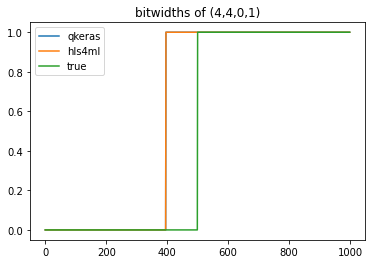

Interpreting Sequential
Topology:
Layer name: q_dense_54_input, layer type: Input
Layer name: q_dense_54, layer type: QDense
Layer name: q_dense_55, layer type: QDense
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'q_dense_54_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'q_dense_54': {'Precision': {'weight': 'ap_fixed<6,5>', 'bias': 'ap_fixed<6,5>'}, 'ReuseFactor': 1}, 'q_dense_55': {'Precision': {'weight': 'ap_fixed<6,5>', 'bias': 'ap_fixed<6,5>'}, 'ReuseFactor': 1}}}
Interpreting Sequential
Topology:
Layer name: q_dense_54_input, layer type: InputLayer, input shapes: [[None, 1]], output shape: [None, 1]
Layer name: q_dense_54, layer type: QDense, input shapes: [[None, 1]], output shape: [None, 10]
Layer name: q_dense_55, layer type: QDense, input shapes: [[None, 10]], output shape: [None, 2]
Creating HLS model
Writing HLS project
Done
32/32 [==============================] - 0s 452us/step


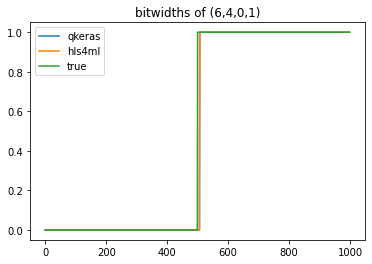

Interpreting Sequential
Topology:
Layer name: q_dense_56_input, layer type: Input
Layer name: q_dense_56, layer type: QDense
Layer name: q_dense_57, layer type: QDense
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'q_dense_56_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'q_dense_56': {'Precision': {'weight': 'ap_fixed<8,5>', 'bias': 'ap_fixed<8,5>'}, 'ReuseFactor': 1}, 'q_dense_57': {'Precision': {'weight': 'ap_fixed<8,5>', 'bias': 'ap_fixed<8,5>'}, 'ReuseFactor': 1}}}
Interpreting Sequential
Topology:
Layer name: q_dense_56_input, layer type: InputLayer, input shapes: [[None, 1]], output shape: [None, 1]
Layer name: q_dense_56, layer type: QDense, input shapes: [[None, 1]], output shape: [None, 10]
Layer name: q_dense_57, layer type: QDense, input shapes: [[None, 10]], output shape: [None, 2]
Creating HLS model
Writing HLS project
Done
32/32 [==============================] - 0s 457us/step


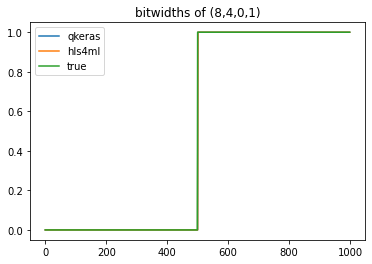

Interpreting Sequential
Topology:
Layer name: q_dense_58_input, layer type: Input
Layer name: q_dense_58, layer type: QDense
Layer name: q_dense_59, layer type: QDense
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'q_dense_58_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'q_dense_58': {'Precision': {'weight': 'ap_fixed<10,5>', 'bias': 'ap_fixed<10,5>'}, 'ReuseFactor': 1}, 'q_dense_59': {'Precision': {'weight': 'ap_fixed<10,5>', 'bias': 'ap_fixed<10,5>'}, 'ReuseFactor': 1}}}
Interpreting Sequential
Topology:
Layer name: q_dense_58_input, layer type: InputLayer, input shapes: [[None, 1]], output shape: [None, 1]
Layer name: q_dense_58, layer type: QDense, input shapes: [[None, 1]], output shape: [None, 10]
Layer name: q_dense_59, layer type: QDense, input shapes: [[None, 10]], output shape: [None, 2]
Creating HLS model
Writing HLS project
Done
32/32 [==============================] - 0s 417us/step


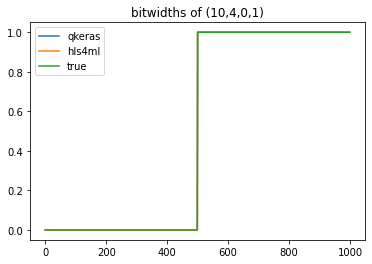

Interpreting Sequential
Topology:
Layer name: q_dense_60_input, layer type: Input
Layer name: q_dense_60, layer type: QDense
Layer name: q_dense_61, layer type: QDense
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'q_dense_60_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'q_dense_60': {'Precision': {'weight': 'ap_fixed<12,5>', 'bias': 'ap_fixed<12,5>'}, 'ReuseFactor': 1}, 'q_dense_61': {'Precision': {'weight': 'ap_fixed<12,5>', 'bias': 'ap_fixed<12,5>'}, 'ReuseFactor': 1}}}
Interpreting Sequential
Topology:
Layer name: q_dense_60_input, layer type: InputLayer, input shapes: [[None, 1]], output shape: [None, 1]
Layer name: q_dense_60, layer type: QDense, input shapes: [[None, 1]], output shape: [None, 10]
Layer name: q_dense_61, layer type: QDense, input shapes: [[None, 10]], output shape: [None, 2]
Creating HLS model
Writing HLS project
Done
32/32 [==============================] - 0s 469us/step


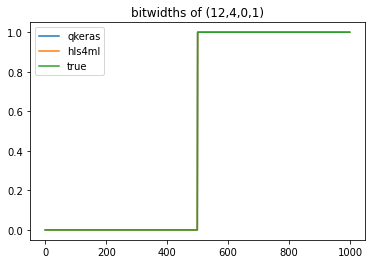

Interpreting Sequential
Topology:
Layer name: q_dense_62_input, layer type: Input
Layer name: q_dense_62, layer type: QDense
Layer name: q_dense_63, layer type: QDense
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'q_dense_62_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'q_dense_62': {'Precision': {'weight': 'ap_fixed<14,5>', 'bias': 'ap_fixed<14,5>'}, 'ReuseFactor': 1}, 'q_dense_63': {'Precision': {'weight': 'ap_fixed<14,5>', 'bias': 'ap_fixed<14,5>'}, 'ReuseFactor': 1}}}
Interpreting Sequential
Topology:
Layer name: q_dense_62_input, layer type: InputLayer, input shapes: [[None, 1]], output shape: [None, 1]
Layer name: q_dense_62, layer type: QDense, input shapes: [[None, 1]], output shape: [None, 10]
Layer name: q_dense_63, layer type: QDense, input shapes: [[None, 10]], output shape: [None, 2]
Creating HLS model
Writing HLS project
Done
32/32 [==============================] - 0s 437us/step


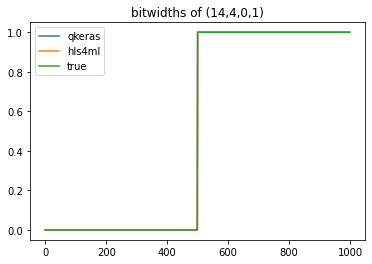

Interpreting Sequential
Topology:
Layer name: q_dense_64_input, layer type: Input
Layer name: q_dense_64, layer type: QDense
Layer name: q_dense_65, layer type: QDense
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'q_dense_64_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'q_dense_64': {'Precision': {'weight': 'ap_fixed<16,5>', 'bias': 'ap_fixed<16,5>'}, 'ReuseFactor': 1}, 'q_dense_65': {'Precision': {'weight': 'ap_fixed<16,5>', 'bias': 'ap_fixed<16,5>'}, 'ReuseFactor': 1}}}
Interpreting Sequential
Topology:
Layer name: q_dense_64_input, layer type: InputLayer, input shapes: [[None, 1]], output shape: [None, 1]
Layer name: q_dense_64, layer type: QDense, input shapes: [[None, 1]], output shape: [None, 10]
Layer name: q_dense_65, layer type: QDense, input shapes: [[None, 10]], output shape: [None, 2]
Creating HLS model
Writing HLS project
Done
32/32 [==============================] - 0s 409us/step


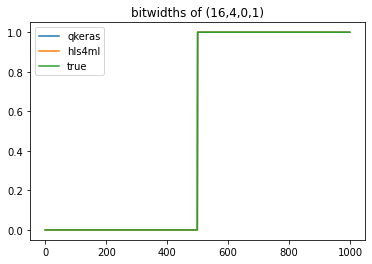

Interpreting Sequential
Topology:
Layer name: q_dense_66_input, layer type: Input
Layer name: q_dense_66, layer type: QDense
Layer name: q_dense_67, layer type: QDense
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'q_dense_66_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'q_dense_66': {'Precision': {'weight': 'ap_fixed<18,5>', 'bias': 'ap_fixed<18,5>'}, 'ReuseFactor': 1}, 'q_dense_67': {'Precision': {'weight': 'ap_fixed<18,5>', 'bias': 'ap_fixed<18,5>'}, 'ReuseFactor': 1}}}
Interpreting Sequential
Topology:
Layer name: q_dense_66_input, layer type: InputLayer, input shapes: [[None, 1]], output shape: [None, 1]
Layer name: q_dense_66, layer type: QDense, input shapes: [[None, 1]], output shape: [None, 10]
Layer name: q_dense_67, layer type: QDense, input shapes: [[None, 10]], output shape: [None, 2]
Creating HLS model
Writing HLS project
Done
32/32 [==============================] - 0s 437us/step


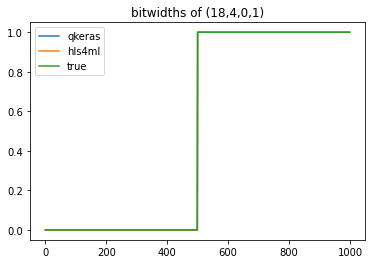

Interpreting Sequential
Topology:
Layer name: q_dense_68_input, layer type: Input
Layer name: q_dense_68, layer type: QDense
Layer name: q_dense_69, layer type: QDense
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'q_dense_68_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'q_dense_68': {'Precision': {'weight': 'ap_fixed<20,5>', 'bias': 'ap_fixed<20,5>'}, 'ReuseFactor': 1}, 'q_dense_69': {'Precision': {'weight': 'ap_fixed<20,5>', 'bias': 'ap_fixed<20,5>'}, 'ReuseFactor': 1}}}
Interpreting Sequential
Topology:
Layer name: q_dense_68_input, layer type: InputLayer, input shapes: [[None, 1]], output shape: [None, 1]
Layer name: q_dense_68, layer type: QDense, input shapes: [[None, 1]], output shape: [None, 10]
Layer name: q_dense_69, layer type: QDense, input shapes: [[None, 10]], output shape: [None, 2]
Creating HLS model
Writing HLS project
Done
32/32 [==============================] - 0s 455us/step


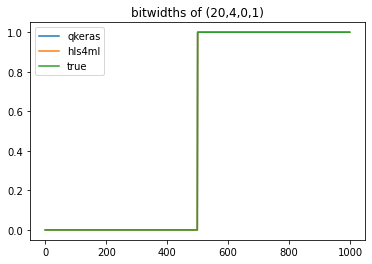

In [85]:
for i in range (9):
    config = hls4ml.utils.config_from_keras_model(qmodels[i], granularity='name')
    print(config)
    hls_model = hls4ml.converters.convert_from_keras_model(qmodels[i],
                                                        hls_config=config,
                                                        output_dir='models/hls_models',
                                                        backend='Quartus')
    hls_model.compile()

    y_qkeras = qmodels[i].predict(x_test)
    y_hls = hls_model.predict(x_test.reshape(x_test.shape[0],1))
    y_keras = d_model.predict(x_test)
    
    plt.plot(np.argmax(y_qkeras, axis=1))
    plt.plot(np.argmax(y_hls, axis=1))
    plt.plot(Y_test)    
    plt.legend(['qkeras', 'hls4ml', 'true'])
    plt.title(f'bitwidths of ({(i+2)*2},4,0,1)')
    plt.show()

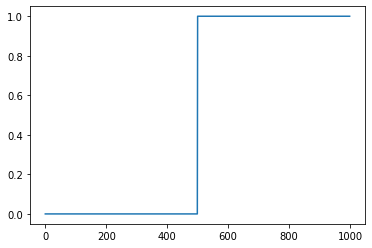

In [86]:
   
plt.plot(np.argmax(y_qkeras, axis=1))
